In [23]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
import datalad.api as dl

In [6]:
cd /project/3022028.02

/project/3022028.02


In [8]:
ls

Sherlock/  tracula_w3_2021/


In [25]:
# define data directory
data_dir = '/project/3022028.02/Sherlock'

# Initialize dataset
ds = dl.Dataset(data_dir)

# Get Cropped & Denoised CSV Files
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*Average_ROI*csv')))

get(ok): fmriprep/sub-07/func/sub-07_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-14/func/sub-14_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-09/func/sub-09_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-01/func/sub-01_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-15/func/sub-15_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-02/func/sub-02_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-06/func/sub-06_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-08/func/sub-08_Part2_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-05/func/sub-05_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-13/func/sub-13_Part1_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-03/func/sub-03_Part2_Average_ROI_n50.csv (file) [from origin...]
get(ok): fmriprep/sub-12/func/sub-12_Part1_

/home/mrstats/chrgon/.conda/envs/naturalistic/lib/python3.7/site-packages/nilearn/image/image.py:756: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  return klass(data, affine, header=header)


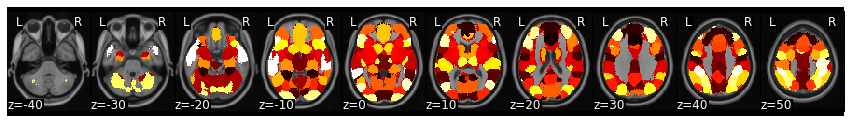

In [28]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)

mask.plot()

In [29]:
# load csv files for each participant
sub_list = [os.path.basename(x).split('_')[0] for x in glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', '*Part1*csv'))]
sub_list.sort()

In [30]:
# combine runs for each participant
sub_timeseries = {}
for sub in sub_list:
    part1 = pd.read_csv(os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_Part1_Average_ROI_n50.csv'))
    part2 = pd.read_csv(os.path.join(data_dir, 'fmriprep', sub, 'func', f'{sub}_Part2_Average_ROI_n50.csv'))
    sub_data = part1.append(part2)
    sub_data.reset_index(inplace=True, drop=True)
    sub_timeseries[sub] = sub_data


,sub-01,sub-02,sub-03,sub-04,sub-05,sub-06,sub-07,sub-08,sub-09,sub-10,sub-11,sub-12,sub-13,sub-14,sub-15,sub-16
0,3.362605,-1.967253,-0.243505,2.527032,5.166227,-0.678549,2.199253,-1.646883e+00,0.421235,0.500547,0.361623,4.639737e+00,1.490442,1.806639,1.039467,3.483579e-13
1,0.995695,1.730923,1.552836,1.068784,4.066954,0.117737,3.184899,8.464993e-01,-0.118011,0.981400,-0.069505,2.522244e+00,1.145760,-0.582861,-0.420722,-1.237187e-13
2,2.084567,-1.940155,1.914897,1.103097,2.168681,0.030628,2.036096,1.782011e-01,0.984125,3.957482,-0.792416,1.326291e+00,0.472309,-3.066318,0.869296,-1.931528e-02
3,-0.217049,-0.636084,1.501459,-0.701397,1.704406,0.042397,2.353035,1.088203e+00,1.650786,3.687806,3.839885,2.105321e-02,-2.885314,-1.212683,1.213115,-1.460159e+00
4,-2.628723,1.650023,-1.196258,0.079026,1.297944,-0.743593,1.188282,3.375227e-13,1.515944,-0.709527,4.874887,2.279356e-13,-5.277045,0.232831,1.914874,1.745742e+00


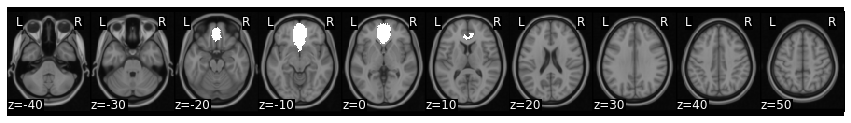

In [31]:
# pick a single ROI (e.g. vmPFC; roi=32)
roi = 32

# plot mask
mask_x[roi].plot()

# create a new pandas DataFrame that has average vmPFC activity for each participant
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

sub_rois = get_subject_roi(sub_timeseries, roi)
sub_rois.head()